In [1]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pwd

/content


In [66]:
# Clone github repository setup
# import join used to join ROOT path and MY_GOOGLE_DRIVE_PATH
from os.path import join  

# path to your project on Google Drive
MY_GOOGLE_DRIVE_PATH = "drive/My Drive/supermario/"
# replace with your Github username 
GIT_USERNAME = "keisukemurota" 
# definitely replace with your
GIT_TOKEN = "192b1acaea94387f7c0eee29af4f10ac97c2f26c"  
# Replace with your github repository in this case we want 
# to clone deep-learning-v2-pytorch repository
GIT_REPOSITORY = "SuperMarioBro" 

PROJECT_PATH = join(ROOT, MY_GOOGLE_DRIVE_PATH)

# It's good to print out the value if you are not sure 
print("PROJECT_PATH: ", PROJECT_PATH)   

# In case we haven't created the folder already; we will create a folder in the project path 
#!mkdir "{PROJECT_PATH}"    

#GIT_PATH = "https://{GIT_TOKEN}@github.com/{GIT_USERNAME}/{GIT_REPOSITORY}.git" this return 400 Bad Request for me
GIT_PATH = "https://" + GIT_TOKEN + "@github.com/" + GIT_USERNAME + "/" + GIT_REPOSITORY + ".git"
print("GIT_PATH: ", GIT_PATH)

PROJECT_PATH:  /content/drive/drive/My Drive/supermario/
GIT_PATH:  https://192b1acaea94387f7c0eee29af4f10ac97c2f26c@github.com/keisukemurota/SuperMarioBro.git


In [72]:
path = "drive/My Drive/supermario/SuperMarioBro"
%cd "{path}"

[Errno 2] No such file or directory: 'drive/My Drive/supermario/SuperMarioBro'
/content/drive/My Drive/supermario


In [92]:
git config --global user.email "mukeisuke0709@gmail.com"

SyntaxError: ignored

In [0]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

Sat Jan  4 06:36:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    31W / 250W |   8945MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# %%capture
%%bash
apt-get install cmake
apt-get install zlib1g-dev
pip install JSAnimation
pip install gym-super-mario-bros

Reading package lists...
Building dependency tree...
Reading state information...
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [0]:
import numpy as np
# import cPickle as pickle
import matplotlib.pyplot as plt
from JSAnimation.IPython_display import display_animation
import gym
from collections import deque
from matplotlib import animation, rc
from IPython.display import HTML

%matplotlib inline

In [0]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1005'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1005'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

Testing env.render with CartPole environment

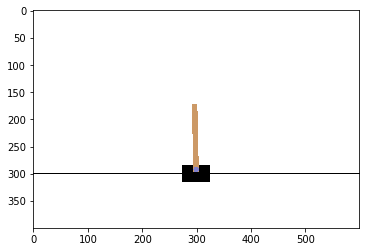

In [0]:
env = gym.make("CartPole-v0")
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)


In [0]:
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [0]:
action_space = env.get_action_meanings()
action_space

['NOOP', 'right', 'right A', 'right B', 'right A B', 'A', 'left']

In [0]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=25)
    return anim

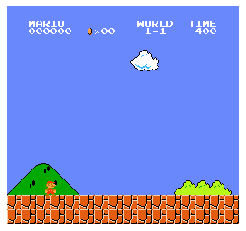

In [0]:
observation = env.reset()
r = []
infos = []
MAX_STEPS = 500
frames = np.zeros((MAX_STEPS, 240, 256, 3), dtype=np.uint8)
xs = []
valid_actions = [1,5,6]
for step in range(MAX_STEPS):
    # Render into buffer. 
    frames[step] = env.render(mode = 'rgb_array')
    observation, reward, done, info = env.step(valid_actions[np.random.randint(3)]) 
    infos.append(info)
    r.append(reward)
    xs.append(info['x_pos'])
    if done:
        break
        

anim = display_frames_as_gif(frames)
# HTML(anim.to_html5_video())

In [0]:
obs=env.reset()
np.shape(obs)

(240, 256, 3)

In [0]:
def preprocess(frame):
    frame = frame.sum(axis=-1)/765
    frame = frame[20:210,100:]
    frame = frame[::2,::2]
    return frame

In [0]:
#anim=display_frames_as_gif([preprocess(frame) for frame in frames])
#HTML(anim.to_html5_video())

In [0]:
# from dqn_agent import DQNAgent
# from models import QNetworkCNN

## Models

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetworkCNN(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, channels, action_size, seed=42):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetworkCNN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.conv1 = nn.Conv2d(channels, 4, 3, padding=1)
        self.conv2 = nn.Conv2d(4, 8, 3, padding=1)
        self.conv3 = nn.Conv2d(8, 16, 3, padding=1)
        self.conv4 = nn.Conv2d(16, 16, 3, padding=1)
        self.conv5 = nn.Conv2d(16, 16, 3, padding=1)
        
        self.pool = nn.MaxPool2d(2, ceil_mode=True)
        
        flat_len = 16*3*3
        self.fc1 = nn.Linear(flat_len, 20)
        self.fc2 = nn.Linear(20, action_size)

    def forward(self, x):
        """Build a network that maps state -> action values."""
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))

        x = x.reshape(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
    
        return x

class QNetworkDuellingCNN(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, channels, action_size, seed=42):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetworkDuellingCNN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.conv1 = nn.Conv2d(channels, 4, 3, padding=1)
        self.conv2 = nn.Conv2d(4, 8, 3, padding=1)
        self.conv3 = nn.Conv2d(8, 16, 3, padding=1)
        self.conv4 = nn.Conv2d(16, 16, 3, padding=1)
        self.conv5 = nn.Conv2d(16, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(4)
        self.bn2 = nn.BatchNorm2d(8)
        self.bn3 = nn.BatchNorm2d(16)
        self.bn4 = nn.BatchNorm2d(16)
        self.bn5 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, ceil_mode=True)
        
        flat_len = 16*3*3
        self.fcval = nn.Linear(flat_len, 20)
        self.fcval2 = nn.Linear(20, 1)
        self.fcadv = nn.Linear(flat_len, 20)
        self.fcadv2 = nn.Linear(20, action_size)

    def forward(self, x):
        """Build a network that maps state -> action values."""
        x = self.pool(
            F.relu(self.bn1(self.conv1(x))))
        
        x = self.pool(
            F.relu(self.bn2(self.conv2(x))))
        
        x = self.pool(
            F.relu(self.bn3(self.conv3(x))))
        
        x = self.pool(
            F.relu(self.bn4(self.conv4(x))))
        
        x = self.pool(
            F.relu(self.bn5(self.conv5(x))))

        
        x = x.reshape(x.shape[0], -1)
        
        advantage = F.relu(self.fcadv(x))
        advantage = self.fcadv2(advantage)
        advantage = advantage - torch.mean(advantage, dim=-1, keepdim=True)
        
        value = F.relu(self.fcval(x))
        value = self.fcval2(value)

        return value + advantage

## Memory buffer
Saves States, Actions, Rewards, Next States (SARS) and Dones.

If priority sampling is required, we sample according to the error of the model.

In [0]:
import torch
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, state_size, action_size, buffer_size, batch_size, priority=False):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer (chosen as multiple of num agents)
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.states = torch.zeros((buffer_size,)+state_size).to(device)
        self.next_states = torch.zeros((buffer_size,)+state_size).to(device)
        self.actions = torch.zeros(buffer_size,1, dtype=torch.long).to(device)
        self.rewards = torch.zeros(buffer_size, 1, dtype=torch.float).to(device)
        self.dones = torch.zeros(buffer_size, 1, dtype=torch.float).to(device)
        self.e = np.zeros((buffer_size, 1), dtype=np.float)
        
        self.priority = priority

        self.ptr = 0
        self.n = 0
        self.buffer_size = buffer_size
        self.batch_size = batch_size
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        self.states[self.ptr] = torch.from_numpy(state).to(device)
        self.next_states[self.ptr] = torch.from_numpy(next_state).to(device)
        self.actions[self.ptr] = action
        self.rewards[self.ptr] = reward
        self.dones[self.ptr] = done
        
        self.ptr += 1
        if self.ptr >= self.buffer_size:
            self.ptr = 0
            self.n = self.buffer_size

    def sample(self, get_all=False):
        """Randomly sample a batch of experiences from memory."""
        n = len(self)
        if get_all:
            return self.states[:n], self.actions[:n], self.rewards[:n], self.next_states[:n], self.dones[:n]
        # else:
        if self.priority:
            idx = np.random.choice(n, self.batch_size, replace=False, p=self.e)
        else:
            idx = np.random.choice(n, self.batch_size, replace=False)
        
        states = self.states[idx]
        next_states = self.next_states[idx]
        actions = self.actions[idx]
        rewards = self.rewards[idx]
        dones = self.dones[idx]
        
        return (states, actions, rewards, next_states, dones), idx
      
    def update_error(self, e, idx=None):
        e = torch.abs(e.detach())
        e = e / e.sum()
        if idx is not None:
            self.e[idx] = e.cpu().numpy()
        else:
            self.e[:len(self)] = e.cpu().numpy()
        
    def __len__(self):
        if self.n == 0:
            return self.ptr
        else:
            return self.n

## Agent
Actual agent and how to respond to the current state of the environment. Uses Models and Memory buffer from before.

y_target = r + gamma * sum(future_rewards)

sum(future_rewards) = q_local(state, action)

In [0]:
import numpy as np
import random
from collections import namedtuple, deque
import itertools

import torch
import torch.nn.functional as F
import torch.optim as optim

# from ReplayBuffer import ReplayBuffer

BUFFER_SIZE = int(5e3)  # replay buffer size
BATCH_SIZE = 256         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4              # learning rate 
UPDATE_EVERY = 10        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            

class DQNAgent():
    """Interacts with and learns from the environment."""

    def __init__(self, model, state_size, action_size, seed=42, ddqn=False, priority=False):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.ddqn = ddqn

        # Q-Network
        self.qnetwork_local = model(state_size[0], action_size, seed).to(device)
        self.qnetwork_target = model(state_size[0], action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(state_size, (action_size,), BUFFER_SIZE, BATCH_SIZE)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done, sum_reward):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        self.sum_reward = sum_reward
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences, idx = self.memory.sample() # fetch all experiences correnponding to idx
                e = self.learn(experiences)
                self.memory.update_error(e, idx)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval() #
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()


        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
          
    def update_error(self):
        states, actions, rewards, next_states, dones = self.memory.sample(get_all=True)
        with torch.no_grad():
            if self.ddqn:
                old_val = self.qnetwork_local(states).gather(-1, actions)
                actions = self.qnetwork_local(next_states).argmax(-1, keepdim=True)
                maxQ = self.qnetwork_target(next_states).gather(-1, actions)
                target = rewards+GAMMA*maxQ*(1-dones)
            else: # Normal DQN
                maxQ = self.qnetwork_target(next_states).max(-1, keepdim=True)[0]
                target = rewards+GAMMA*maxQ*(1-dones)
                old_val = self.qnetwork_local(states).gather(-1, actions)
            e = old_val - target
            self.memory.update_error(e)

    def learn(self, experiences):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        ## compute and minimize the loss
        self.optimizer.zero_grad()
        if self.ddqn:
            old_val = self.qnetwork_local(states).gather(-1, actions) #Q(s,a,old_theta)
            with torch.no_grad():
                next_actions = self.qnetwork_local(next_states).argmax(-1, keepdim=True)
                maxQ = self.qnetwork_target(next_states).gather(-1, next_actions)
                target = rewards+GAMMA*maxQ*(1-dones)
        else: # Normal DQN
            with torch.no_grad():
                maxQ = self.qnetwork_target(next_states).max(-1, keepdim=True)[0]
                target = rewards+GAMMA*maxQ*(1-dones)
            old_val = self.qnetwork_local(states).gather(-1, actions)   
        
        loss = F.mse_loss(old_val, target) #mean square error
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU) 
        
        return old_val - target


    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        self.sum_reward = 400/self.sum_reward
        #tau *= self.sum_reward
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

## Edit Reward system


In [0]:
class make_wrapper(gym.Wrapper):
    def __init__(self, env=None):
        """Return only every `skip`-th frame"""
        super(make_wrapper, self).__init__(env)
        self.x = 40

    def step(self, action):
        total_reward = 0
        for _ in range(2):
            obs, reward, done, info = self.env.step(action) #Using the same action during for loop.
            total_reward += reward
            if done or reward < -10:
                break
        
        self.x_old = self.x
        self.x = info["x_pos"]
        if self.x_old >= self.x:
            total_reward -= 0.5
        return obs, total_reward, done, info

In [0]:
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = make_wrapper(env)

## Train Agent
We step through different iterations of the environment to learn the optimal action for a given state.

In [0]:
episode = 100
discount_rate = .99
noise = 0.05
noise_decay = 0.99
tmax = 200
target_reward = 1500

# keep track of progress
sum_rewards = [0]


# keep track of frames
FRAME_SHAPE = (95, 78) #(210-20)/2 , 256/2
MAX_FRAMES = 4
nn_frames = deque(maxlen=MAX_FRAMES)
for i in range(MAX_FRAMES):
    nn_frames.append(np.zeros(FRAME_SHAPE))
    
action_size = 7 #len(valid_actions)
state_size = (MAX_FRAMES,) + FRAME_SHAPE
agent = DQNAgent(QNetworkDuellingCNN, state_size, action_size, ddqn=True, priority=True)
e = 0
while np.mean(sum_rewards[-5:]) < target_reward:
    obs = env.reset()
    prev_obs = None
    sum_reward = 0
    
    for i in range(MAX_FRAMES):
        nn_frames.append(np.zeros(FRAME_SHAPE)) # elements of the deque are all zero
    nn_frames.append(np.copy(preprocess(obs)))
    states = np.array(nn_frames)
    for t in range(tmax):
        actions = agent.act(states, noise)
        obs, reward, done, _ = env.step(actions)
        nn_frames.append(np.copy(preprocess(obs)))
        next_states = np.array(nn_frames)
        
        agent.step(states, int(actions), int(reward), next_states, int(done), int(sum_rewards[-1]))
        sum_reward += reward
        states = next_states
        if done or reward < -10: # if mario die or game clear
            break
    
    agent.update_error()
    sum_rewards.append(sum_reward)
    noise = noise * noise_decay
    e += 1
    print('\rEpisode {}\tCurrent Score: {:.2f}'.format(e, sum_rewards[-1]), end="")
    # display some progress every 20 iterations
    if (e+1) % (episode // 20) ==0:
        tmax = int(np.mean(sum_rewards[-5:])*1.3)
        print(" | Episode: {0:d}, average score: {1:f}, tmax : {2:d}".format(e+1,np.mean(sum_rewards[-20:]),tmax))
        

Episode 1	Current Score: -106.50

/usr/local/lib/python3.6/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 4	Current Score: 230.00 | Episode: 5, average score: 108.700000, tmax : 141
Episode 9	Current Score: 454.00 | Episode: 10, average score: 205.700000, tmax : 393
Episode 14	Current Score: 230.00 | Episode: 15, average score: 213.800000, tmax : 299
Episode 19	Current Score: 275.50 | Episode: 20, average score: 220.075000, tmax : 310
Episode 24	Current Score: 230.00 | Episode: 25, average score: 250.825000, tmax : 301
Episode 29	Current Score: 230.00 | Episode: 30, average score: 234.800000, tmax : 310
Episode 34	Current Score: 230.00 | Episode: 35, average score: 256.575000, tmax : 412
Episode 39	Current Score: 688.00 | Episode: 40, average score: 301.650000, tmax : 544
Episode 44	Current Score: 609.50 | Episode: 45, average score: 354.850000, tmax : 577
Episode 49	Current Score: 639.00 | Episode: 50, average score: 427.350000, tmax : 687
Episode 54	Current Score: 496.00 | Episode: 55, average score: 477.500000, tmax : 673
Episode 59	Current Score: 1032.50 | Episode: 60, average 

KeyboardInterrupt: ignored

In [0]:
plt.plot(sum_rewards)
plt.show()

In [0]:
obs = env.reset()
prev_obs = None
sum_reward = 0

frames = np.zeros((2000, 240, 256, 3), dtype=np.uint8)

for i in range(MAX_FRAMES):
  nn_frames.append(np.zeros(FRAME_SHAPE))
nn_frames.append(np.copy(preprocess(obs)))
states = np.array(nn_frames)
rs = []
xs = []
ys = []
i=0
for t in range(2000):
    i += 1
    frames[t] = obs
    actions = agent.act(states, noise)
    obs, reward, done, info = env.step(actions)
    nn_frames.append(np.copy(preprocess(obs)))
    next_states = np.array(nn_frames)

    sum_reward += reward
    states = next_states
    rs.append(reward)
    xs.append(info['x_pos'])
    ys.append(info['y_pos'])
    if done:
        print("i=",i)
        break

print('Sum of rewards is ', sum(rs))
plt.plot(rs)
plt.show()

plt.plot(xs)
plt.show()

anim=display_frames_as_gif(frames)


/usr/local/lib/python3.6/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


KeyboardInterrupt: ignored

In [0]:
print(np.shape(rs),i)
print(done)

(528,) 528
True


In [0]:
HTML(anim.to_html5_video())


In [0]:
! git clone https://github.com/keisukemurota/SuperMarioBro.git

Cloning into 'SuperMarioBro'...
remote: Enumerating objects: 151, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 151 (delta 81), reused 111 (delta 51), pack-reused 0
Receiving objects: 100% (151/151), 9.71 MiB | 17.38 MiB/s, done.
Resolving deltas: 100% (81/81), done.


In [0]:
%cd SuperMarioBro/

/content/SuperMarioBro


In [0]:
! git status

On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean


In [0]:
! ls

'hello world.ipynb'   README.md		        test.py
'README copy.md'      SuperDeepMarioBro.ipynb
